<a href="https://colab.research.google.com/github/Vkanishka/Building-Your-Own-GPT/blob/main/Building_Your_Own_GPT_An_Introduction_to_the_Transformer_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Building Your Own GPT - An Introduction to the Transformer Architecture

# Plan for Today



- Explore the evolution of neural networks for sequence modeling, culminating in building our own GPT-style transformer model from scratch.

- Start with the basics and move quickly
  - don't despair if you lose me, at times I'll dip into more technical detail, but not understanding one part of the workshop won't prevent you getting value from the subsequent sections
- The goal is for everyone to learn something regardless of background
- Try not to *read your way through the material* - I've included all of the text in this notebook so that you have access to it if you want to review the materials later, normally I would hide it all in speaker notes.
- You can access this notebook at tinyurl.com/TonyWorkshop

# 1. Background

## 1.2 The What and Why of Deep Learning


### Machine Learning and Deep Learning Explained

* **Machine Learning**: A subfield of AI where algorithms learn patterns from data without being explicitly programmed
  * ML systems improve through experience - they "learn" rather than follow fixed instructions
  * The more quality data they process, the better they typically perform

* Until the last ~15 years, machine learning relied heavily on **feature engineering**:
  * **Features**: Carefully selected properties extracted from raw data that help algorithms make predictions
  * **Feature Engineering**: The expert-driven process of identifying and transforming relevant data characteristics
    * Example: For facial recognition, manually defining features like distance between eyes or nose shape

* **Deep Learning Revolution**: Discover representations automatically from data
  * Uses neural networks with multiple layers ("deep" architecture)
  * Automatically extracts hierarchical features without human intervention
  * Requires large amounts of data to approximate complex functions



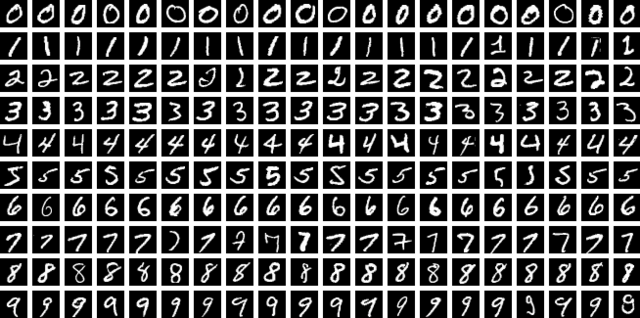

### Real-World Example: Handwritten Digit Recognition

**Traditional ML Approach:**
* Engineer features like: straight lines, curved edges, loops, intersections
* Create rules for each digit based on these features
* Limitations: Tedious, brittle, struggles with variation in handwriting

**Deep Learning Approach:**
* Feed thousands of digit images directly to neural networks
* The system is *trained* to extract features automatically
* Learning is driven by feedback (correct vs. incorrect classifications)
* Result: Far more robust recognition that handles natural variation

This same principle applies broadly: We can recognize cats from dogs instantly, but hand-coding that distinction is nearly impossible. Deep learning bridges this gap by learning the distinguishing features directly from examples.

We'll start by visualizing a non-linearly separable dataset to understand why deep learning is powerful:

- What do I mean when I say non-linearly separable?

In [ ]:
# 1.2. The What and Why of Deep Learning
# Generate a non-linearly separable dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title('Non-linearly Separable Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

NameError: name 'make_moons' is not defined

## 1.3 Feedforward Neural Networks

Let's understand the basic building blocks of neural networks:

- Neurons: The basic computational units that receive input, apply a transformation, and produce output

- Layers:
  - Input Layer: Receives the raw data
  - Hidden Layers: Intermediate layers where the complex patterns are learned
  - Output Layer: Produces the final prediction or decision

- Weights and Biases:
Each connection between neurons has an associated weight, and each neuron has a bias. These are the parameters the network learns during training.

- Forward Propagation: The process of passing data through the network from input to output

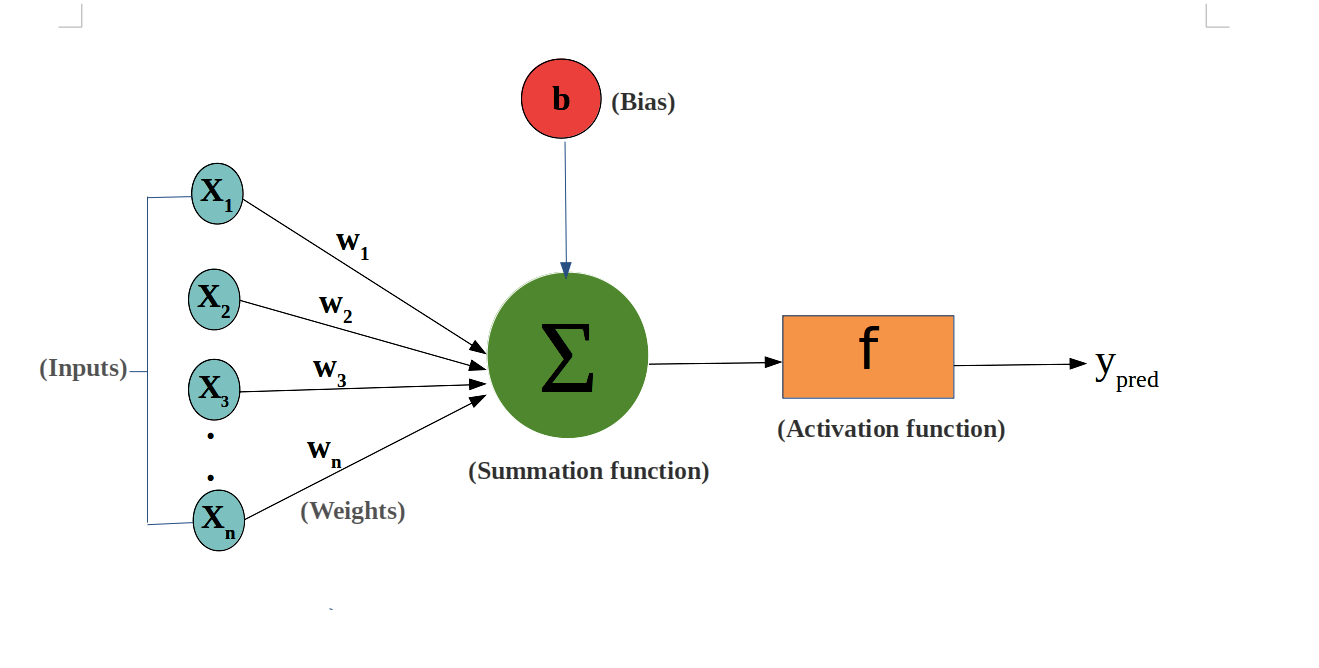

#### Why Neural Networks Work:
the *Universal Approximation Theorem*
- fundamental theorem that proves that a single layer neural net can approximate any continuous function (*on compact subsets of R^n, under mild assumptions about the activation function.)*
- aka neural nets are extremely flexible learning systems


#### **More Detail on the Structure of a Neural Network**


- **Neuron**: Basic unit of a NN, which receive inputs, process them, and pass outputs to other neurons.
    - **Weights**: Parameters that determine the strength and direction of the connection between neurons. They are adjusted during training to minimize the error in predictions.
    - **Biases**: Additional parameters in each neuron that allow the model to fit the data better by providing a way to shift the activation function.
    - **Activation Functions**: Applied to the output of each neuron. They introduce non-linearity. Without them, NNs would only be able to learn linear functions.

- **Layers**: Neurons are organized into layers:
  - **Input Layer**: The first layer, which receives the raw data.
  - **Hidden Layers**: Intermediate layers where the neurons perform computations and extract features from the data.
  - **Output Layer**: The final layer, which produces the network's prediction or decision.

#### Training Steps

1. **Initialization**: Set initial weights and biases.
2. **Forward Propagation**: Process data through the network to get predictions.
3. **Loss Calculation**: Compare predictions to actual values.
4. **Backpropagation**: Adjust weights to minimize loss.
5. **Iteration**: Repeat the process to improve performance.

## 1.4 Activation Functions


Activation functions introduce non-linearity into neural networks, allowing them to learn complex patterns:

### Bonus Material: Activation Functions


#### Sigmoid Activation Function

The sigmoid activation function is a type of logistic function that maps any real-valued number into a value between 0 and 1. The sigmoid function is defined as:

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

**Use Case:**
The sigmoid function is often used in the output layer of binary classification problems.

#### GELU (Gaussian Error Linear Unit) Activation Function

The GELU activation function is a more recent development that combines properties of both linear and non-linear activation functions. It is defined as:

$$ \text{GELU}(x) = x \cdot \Phi(x) $$

where $ \Phi(x) $ is the cumulative distribution function of the standard normal distribution. A simpler, approximate form commonly used in practice is:

$$ \text{GELU}(x) = 0.5x \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} (x + 0.044715x^3)\right)\right) $$

**Use Case:**
GELU is particularly popular in Transformer-based models, where it has shown to improve performance over other activation functions like ReLU and its variants. In essence it is a smooth, differentiable approximation of ReLU.


#### Softmax Activation Function

The softmax activation function is used to convert a vector of values into a probability distribution. The softmax function is defined as:

$$ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}} $$

for \( i = 1, 2, ..., n \), where \( n \) is the number of classes.

**Use Case:**
The softmax function is commonly used in the output layer of neural networks for multi-class classification problems, ensuring that the output probabilities sum to 1.

In [ ]:
# 1.4 Activation Functions
# Define and visualize common activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

# Generate x values
x = np.linspace(-5, 5, 200)

# Compute activations
sigmoid_y = sigmoid(x)
relu_y = relu(x)
gelu_y = gelu(x)

# Plot activations
plt.figure(figsize=(15, 5))

# Sigmoid
plt.subplot(1, 3, 1)
plt.plot(x, sigmoid_y, 'b-', linewidth=2)
plt.title('Sigmoid Activation')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')

# ReLU
plt.subplot(1, 3, 2)
plt.plot(x, relu_y, 'r-', linewidth=2)
plt.title('ReLU Activation')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('ReLU(x)')

# GELU
plt.subplot(1, 3, 3)
plt.plot(x, gelu_y, 'g-', linewidth=2)
plt.title('GELU Activation (used in GPT-3)')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('GELU(x)')

plt.tight_layout()
plt.show()

## 1.5 Backpropagation

Backpropagation is the algorithm used to train neural networks aka *it is how they learn* through gradient-based optimisation:

1. Forward Pass: Compute predictions
2. Calculate Loss: Compare predictions to actual (ground truth) values using a loss function
3. Backward Pass: Propagate gradients back through the network layer by layer. (Gradients of the loss with respect to each parameter are computed via the chain rule, propagating error derivatives backward through the network)
4. Update Weights - Gradient Descent: Parameters (weights and biases) are updated in the direction opposite to their gradients, scaled by a learning rate, to minimize the loss function (improve predictions)

### Real-World Analogy: Blindy Descending a Mountain



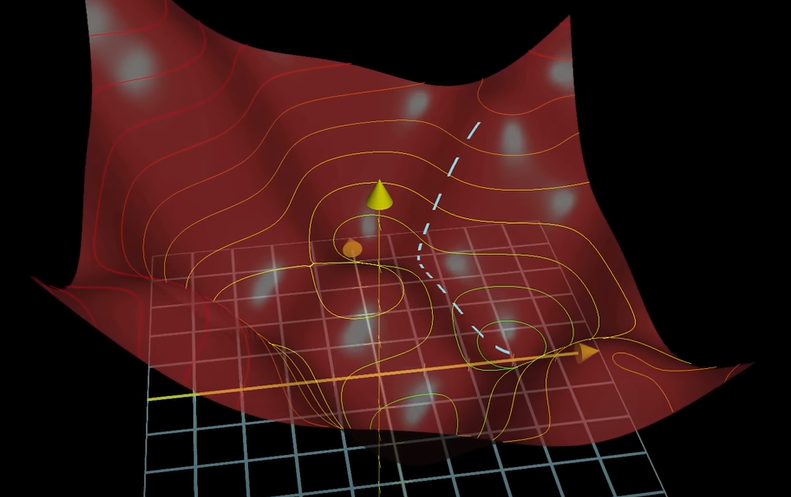

#### Example of Local vs Global Minima

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

# Define a function with multiple local minima
def objective_function(x, y):
    return np.sin(x) * np.cos(y) + 0.5 * x**2 + 0.5 * y**2 + 2 * np.sin(2*x) * np.sin(y) - 2

# Calculate the gradient of the objective function
def gradient(x, y):
    # Numerical gradient approximation
    epsilon = 1e-7
    dx = (objective_function(x + epsilon, y) - objective_function(x - epsilon, y)) / (2 * epsilon)
    dy = (objective_function(x, y + epsilon) - objective_function(x, y - epsilon)) / (2 * epsilon)
    return np.array([dx, dy])

# Set up the meshgrid for visualization
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = objective_function(X, Y)

# Initialize the plot
fig = plt.figure(figsize=(15, 15))

# 3D Surface plot
ax1 = fig.add_subplot(221, projection='3d')
surface = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7, edgecolor='none')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('f(X, Y)')
ax1.set_title('Objective Function with Multiple Local Minima')
ax1.view_init(elev=30, azim=45)  # Set a better viewing angle

# Contour plot
ax2 = fig.add_subplot(222)
contour = ax2.contourf(X, Y, Z, 20, cmap='coolwarm')  # Fewer contour levels for clarity
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Contour Plot with Gradient Descent Path')
plt.colorbar(contour, ax=ax2, label='f(X, Y)')

# Add slice views (cross-sections)
ax3 = fig.add_subplot(223)
# X-axis slice at the eventual y-value of the local minimum
y_slice_idx = np.argmin(np.abs(y - 1.0))  # Approximate y-value of local minimum
ax3.plot(x, Z[y_slice_idx, :], 'b-', linewidth=2)
ax3.set_xlabel('X')
ax3.set_ylabel('f(X, Y=const)')
ax3.set_title('X-axis Slice View (Y held constant)')
ax3.grid(True)

ax4 = fig.add_subplot(224)
# Y-axis slice at the eventual x-value of the local minimum
x_slice_idx = np.argmin(np.abs(x - 1.0))  # Approximate x-value of local minimum
ax4.plot(y, Z[:, x_slice_idx], 'r-', linewidth=2)
ax4.set_xlabel('Y')
ax4.set_ylabel('f(X=const, Y)')
ax4.set_title('Y-axis Slice View (X held constant)')
ax4.grid(True)

# Run gradient descent from a specific starting point
# Starting point chosen to converge to a local, not global minimum
learning_rate = 0.05  # Smaller learning rate for smoother trajectory
max_iterations = 300  # More iterations to ensure convergence from farther away

# Choose a starting point that will lead to a local minimum but is far away
x_start = 2.5
y_start = 2.5
trajectory = []

# Store the current position
x_current, y_current = x_start, y_start
trajectory.append((x_current, y_current))

# Perform gradient descent
for i in range(max_iterations):
    # Calculate gradient
    grad = gradient(x_current, y_current)

    # Update position
    x_current -= learning_rate * grad[0]
    y_current -= learning_rate * grad[1]

    # Store the new position
    trajectory.append((x_current, y_current))

    # Check for convergence
    if np.linalg.norm(grad) < 1e-6:
        break

# Convert trajectory to arrays for plotting
trajectory = np.array(trajectory)

# Plot the trajectory on plots
ax1.plot(trajectory[:, 0], trajectory[:, 1],
         [objective_function(x, y) for x, y in trajectory],
         'ro-', markersize=4, linewidth=2, label='Gradient Descent Path')

ax2.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', markersize=4, linewidth=2, label='Gradient Descent Path')

# Add the final points to the slice views
ax3.scatter(trajectory[-1, 0], objective_function(trajectory[-1, 0], trajectory[-1, 1]),
           color='blue', s=100, label='Local Minimum')
ax3.scatter(x_global_min, objective_function(x_global_min, y_global_min),
           color='green', s=100, label='Global Minimum')
ax3.legend()

ax4.scatter(trajectory[-1, 1], objective_function(trajectory[-1, 0], trajectory[-1, 1]),
           color='blue', s=100, label='Local Minimum')
ax4.scatter(y_global_min, objective_function(x_global_min, y_global_min),
           color='green', s=100, label='Global Minimum')
ax4.legend()

# Mark global minimum
# Find the global minimum (approximately)
indices = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
x_global_min, y_global_min = X[indices], Y[indices]
z_global_min = Z[indices]

ax1.scatter([x_global_min], [y_global_min], [z_global_min], color='green', s=100, label='Global Minimum')
ax2.scatter([x_global_min], [y_global_min], color='green', s=100, label='Global Minimum')

# Mark the local minimum where our trajectory converges
x_local_min, y_local_min = trajectory[-1]
z_local_min = objective_function(x_local_min, y_local_min)

ax1.scatter([x_local_min], [y_local_min], [z_local_min], color='blue', s=100, label='Local Minimum')
ax2.scatter([x_local_min], [y_local_min], color='blue', s=100, label='Local Minimum')

# Mark the starting point
ax1.scatter([x_start], [y_start], [objective_function(x_start, y_start)], color='magenta', s=100, label='Starting Point')
ax2.scatter([x_start], [y_start], color='magenta', s=100, label='Starting Point')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('gradient_descent_local_minimum.png', dpi=300)
plt.show()

# Alternatively, create an animation of the gradient descent process
fig_anim = plt.figure(figsize=(10, 8))
ax_anim = fig_anim.add_subplot(111)
contour_anim = ax_anim.contourf(X, Y, Z, 50, cmap='viridis')
plt.colorbar(contour_anim, label='f(X, Y)')
ax_anim.set_xlabel('X')
ax_anim.set_ylabel('Y')
ax_anim.set_title('Gradient Descent Animation: Converging to a Local Minimum')

line, = ax_anim.plot([], [], 'ro-', linewidth=2)
point, = ax_anim.plot([], [], 'bo', markersize=10)
ax_anim.plot(x_global_min, y_global_min, 'g*', markersize=15, label='Global Minimum')
ax_anim.legend()

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(trajectory[:i+1, 0], trajectory[:i+1, 1])
    point.set_data(trajectory[i:i+1, 0], trajectory[i:i+1, 1])
    return line, point

ani = FuncAnimation(fig_anim, animate, frames=len(trajectory),
                    init_func=init, blit=True, interval=500) # 5x slower (500ms instead of 100ms)

# Uncomment to save the animation (requires ffmpeg or imagemagick)
ani.save('gradient_descent_animation.gif', writer='imagemagick', fps=2) # Slower animation

plt.tight_layout()
plt.show()

**Why Gradient Descent Finding Local Minima Isn't a Deal-Breaker**

In high-dimensional neural networks:
- The loss landscape contains countless local minima
- Most local minima are actually "good enough" solutions
- The probability of getting trapped in a truly poor local minimum decreases as dimensions increase

**Practical Solutions**

1. **Stochastic Gradient Descent (SGD)** introduces noise through mini-batches, helping models:
   - Escape shallow local minima
   - Explore the parameter space more broadly

2. **Modern Optimizers Improve Convergence:**
   - **Momentum:** Accelerates along consistent directions, helping overcome small obstacles
   - **Adam:** Adapts learning rates per parameter and incorporates momentum
   - **RMSProp:** Normalizes gradients to navigate ravines more effectively

3. **Ensemble Methods:** Training multiple networks with different initializations mitigates the impact of any single suboptimal solution


## 1.6 Bonus Material - Building a Simple Feed Forward Neural Net



* For simplicity and readability, the sigmoid function and its derivative are defined outside of the function for the shallow neural net.
* Firstly, as in the logistic regression algorithm, the weights and biases are initialised to small random values.
* Because we are implementing stochastic gradient descent, a single training case is selected at a time.
* In the forward propagation step, the output prediction y_hat is computed for the training case. Then, in the backprop step, the error for this single training case is calculated (delta2), and then the error is propagated back to the hidden layer to get delta1. The weights and biases of the network are updated in the direction that reduces the error, scaled by the set learning rate alpha.
* We stop training if convergence is reached or if we reach a maximum number of iterations without convergence.
* The final weights (W1, W2) and biases (b1, b2) represent the learned parameters of the network and can be used to make predictions on new data points.

In [ ]:
# define the logistic / sigmoid function
def logistic_function(z):
    return 1 / (1 + np.exp(-z))


# define the derivative of the logistic / sigmoid function
def sigmoid_derivative(x):
    return logistic_function(x) * (1 - logistic_function(x))

In [ ]:
# define the shallow_neural_net
def shallow_neural_network(X, y, n_hidden):
    np.random.seed(0)  # setting random seed for reproducibility
    alpha = 0.01  # learning rate
    max_iterations = 1000000  # maximum number of iterations
    threshold = 1e-4  # convergence threshold
    N, n_input = X.shape  # number of examples and input features

    # initalise weights and biases to valid initial values (small random values)
    W1 = np.random.normal(0, 0.01, (n_input, n_hidden))  # weights from input to hidden layer
    b1 = np.random.normal(0, 0.01, n_hidden)  # biases for hidden layer
    W2 = np.random.normal(0, 0.01, n_hidden)  # weights from hidden to output layer
    b2 = np.random.normal(0, 0.01)  # bias for output layer

    # initialize variables related to the stopping criteria
    stopping = False
    J_running = 0
    J_running_prev = 0
    iteration = 0

    while not stopping:
        # select a training example at random
        random_case = np.random.randint(N)
        x_i = X[random_case, :]
        y_i = y[random_case]

        # forward prop stage
        z1 = np.dot(x_i, W1) + b1
        a1 = logistic_function(z1)
        z2 = np.dot(a1, W2) + b2
        y_hat = logistic_function(z2)  # output prediction

        # back prop stage
        delta2 = y_hat - y_i
        delta1 = np.dot(W2, delta2) * sigmoid_derivative(z1) #

        # update weights and biases
        for j in range(n_hidden):
            W2[j] -= alpha * delta2 * a1[j]
            b2 -= alpha * delta2
            for i in range(n_input):
                W1[i, j] -= alpha * delta1[j] * x_i[i]
                b1[j] -= alpha * delta1[j]

        # compute the current cost
        J_current = -np.sum(y_i * np.log(y_hat) + (1 - y_i) * np.log(1 - y_hat))

        # check stopping criteria

        iteration += 1
        J_running += J_current

        if iteration > max_iterations:  # failed to converge
            stopping = True
            print("Stopping: Reached maximum iterations without convergence.")

        if iteration % N == 0:  # test for convergence on the batch
            if abs(J_running - J_running_prev) < threshold:
                stopping = True
            J_running_prev = J_running
            J_running = 0  # reset cost for the next N iterations

    # reshape the weights into the correct format
    W1 = W1.reshape(n_input, n_hidden)
    W2 = W2.reshape(n_hidden, 1)

    return W1, b1, W2, b2 # return the trained weights and biases

In [ ]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the shallow neural network on the moons dataset
W1, b1, W2, b2 = shallow_neural_network(X_train, y_train, n_hidden=4)


In [ ]:
# Define the prediction function
def predict(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = logistic_function(z1)
    z2 = np.dot(a1, W2) + b2
    y_hat = logistic_function(z2)  # output predictions as probabilities
    return y_hat

# convert probabilities to class labels
def predict_labels(y_hat, threshold=0.5):
    return (y_hat > threshold).astype(int)

# predictions
y_hat_prob = predict(X_test, W1, b1, W2, b2)
y_pred = predict_labels(y_hat_prob)

# classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# Helper functions that were not in your code
def logistic_function(z):
    return 1 / (1 + np.exp(-z))

# Function to plot the decision boundary
def plot_decision_boundary(X, y, W1, b1, W2, b2):
    # Set min and max values with some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a meshgrid
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten the meshgrid points for prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict using the trained neural network
    Z = predict(mesh_points, W1, b1, W2, b2)
    Z = Z.reshape(xx.shape)

    # Create a custom colormap
    cmap = mcolors.ListedColormap(['#FFAAAA', '#AAAAFF'])

    # Create figure and axis explicitly
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap)

    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=cmap)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title('Decision Boundary for Shallow Neural Network (Hidden Neurons: {})'.format(W1.shape[1]))
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    # Add a legend
    ax.legend(*scatter.legend_elements(), title="Classes")

    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add colorbar using the contour object
    fig.colorbar(contour, ax=ax)

    plt.tight_layout()
    plt.show()

    return fig, ax

# Prediction function for visualization
def predict(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = logistic_function(z1)
    z2 = np.dot(a1, W2) + b2
    y_hat = logistic_function(z2)
    return y_hat

# Example usage:
plot_decision_boundary(X, y, W1, b1, W2, b2)

## 1.7 Section 1 Checkpoint

Key Takeaways:
- Deep learning enables automatic feature learning from data
- Neural networks consist of interconnected layers of artificial neurons
- Activation functions add non-linearity, allowing networks to learn complex patterns
- Backpropagation is the algorithm that enables learning through error correction

Concept Check:
- What would happen if we removed all activation functions from a neural network?
- How is the error used to update the network's weights?

# 2. Sequence Modelling

Many important problems involve sequence data - data where order matters:
1. Text (sentences, paragraphs, documents)
2. Time series (stock prices, weather patterns)
3. Audio (speech, music)
4. Genetic sequences (DNA, proteins)

Standard feedforward neural networks struggle with sequence data for two main reasons:
1. No Memory: Each input is processed independently - the network has no "memory" of previous inputs
2. Fixed Input Size: Traditional neural networks expect inputs of a fixed size, but sequences can vary in length

To illustrate the problem, consider language: "The cat sat on the mat"
- The meaning of "sat" depends on knowing "cat" came before it
- If we process each word independently, we lose this crucial context

We need architectures specifically designed to handle ordered, variable-length sequences.

## 2.1 Sequence Modelling Example - Next Value Prediction in a Sine Wave Sequence



**Objective**:
- Given a sequence of points from a sine wave, predict the next value.
  - This is an example of many-to-one sequence prediction

**Data Generation**:
- Generate sequences of sine wave values.
- For each sequence, use the first n-1 values as the input and the n-th value as the target.

In [ ]:
# Function to create sample data with noise
def create_data(seq_length, num_samples, noise_std=0.05):
    X = []
    y = []
    for _ in range(num_samples):
        start = np.random.rand() * 2 * np.pi
        end = start + seq_length * 0.1
        seq = np.sin(np.linspace(start, end, seq_length))
        seq += np.random.normal(0, noise_std, seq.shape)  # Add Gaussian noise
        X.append(seq[:-1])
        y.append(seq[-1])
    return np.array(X), np.array(y)
# Parameters for the sample data
seq_length = 50
num_samples = 1000

# Generate the sample data with reduced noise
X, y = create_data(seq_length, num_samples)
# Convert the data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Plotting the sequence and the target value
plt.figure(figsize=(10, 6))
# Plot the first sequence from the data
plt.scatter(range(seq_length - 1), X[0], color='blue', marker='o', label='Input Sequence')
# Plot the target value
plt.scatter(seq_length - 1, y[0], color='red', marker='x', label='Target Value')
# Adding labels and title
plt.xlabel('Time Steps')
plt.ylabel('Sine Value')
plt.title('Sine Wave Sequence and Target Value')
plt.legend()
plt.show()


## 2.2 RNNs


In **feed-forward NNs**, data flows forward from **earlier layers to later layers**.

RNNs introduce a hidden memory state that carries information between time steps, allowing the network to "remember" previous inputs.





**Recurrent networks** - data flows forward but also flows ‘backward’ from later layers (in this time step) to earlier layers (in the next time step)
- There is a hidden state, which is like a memory that captures information from previous time steps.
- This hidden state is updated at each time step based on the current input and the previous hidden state.

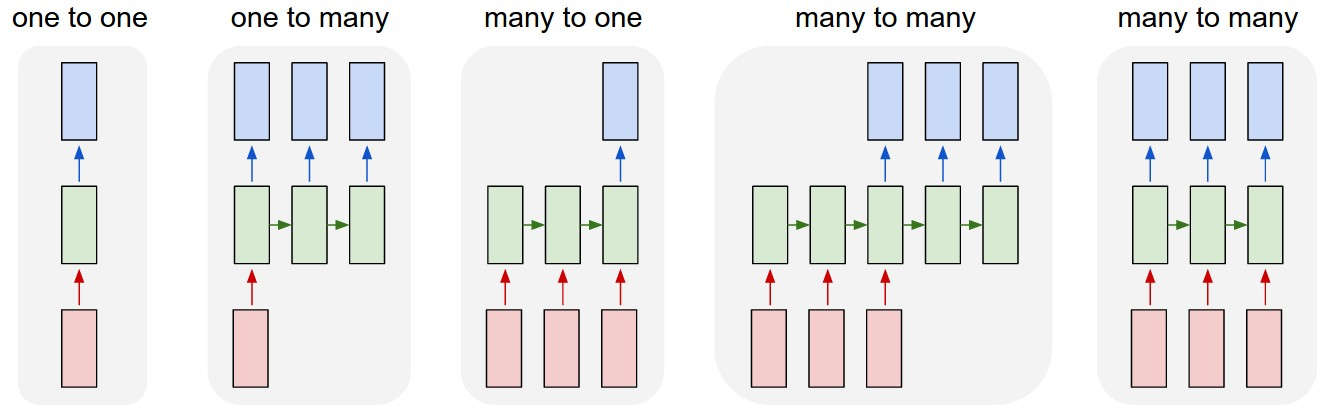

RNNs allow us to do all sorts of tasks
- One-to-one
    - FNN, from fixed-sized input to fixed-sized output (e.g. image classification).
- One-to-many
    - Takes in a single input e.g. an image and returns a sequence output - a sentence caption for the image
- Many-to-one
    - Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment).
- Many-to-many
    - Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French).
- Many-to-many synced
    - Synced sequence input and output (e.g. video classification where we wish to label each frame of the video).

- Notice that in every case where we use a RNNS there is no pre-specified constraints on the length of sequences

In [ ]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters for the model
input_size = 1
hidden_size = 16
output_size = 1
num_epochs = 100
learning_rate = 0.01

# Instantiate the model, loss function, and optimizer
rnn_model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)


In [ ]:
# Training loop for RNN
rnn_train_losses = []
rnn_test_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    outputs = rnn_model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        rnn_model.eval()
        with torch.no_grad():
            train_loss = criterion(rnn_model(X_train), y_train).item()
            test_loss = criterion(rnn_model(X_test), y_test).item()
            rnn_train_losses.append(train_loss)
            rnn_test_losses.append(test_loss)
            print(f'RNN Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


### 2.2.1 RNNs and Long-Term Dependencies
- RNNs can become very deep; if we have a long sequence we have a lot of steps forward in the neural network
- When we multiply steps out in backpropogation the gradients often vanish or explode over time
    - infomation from early steps in the sequence is forgotten


- [Were RNNs All We Needed?](https://arxiv.org/pdf/2410.01201)

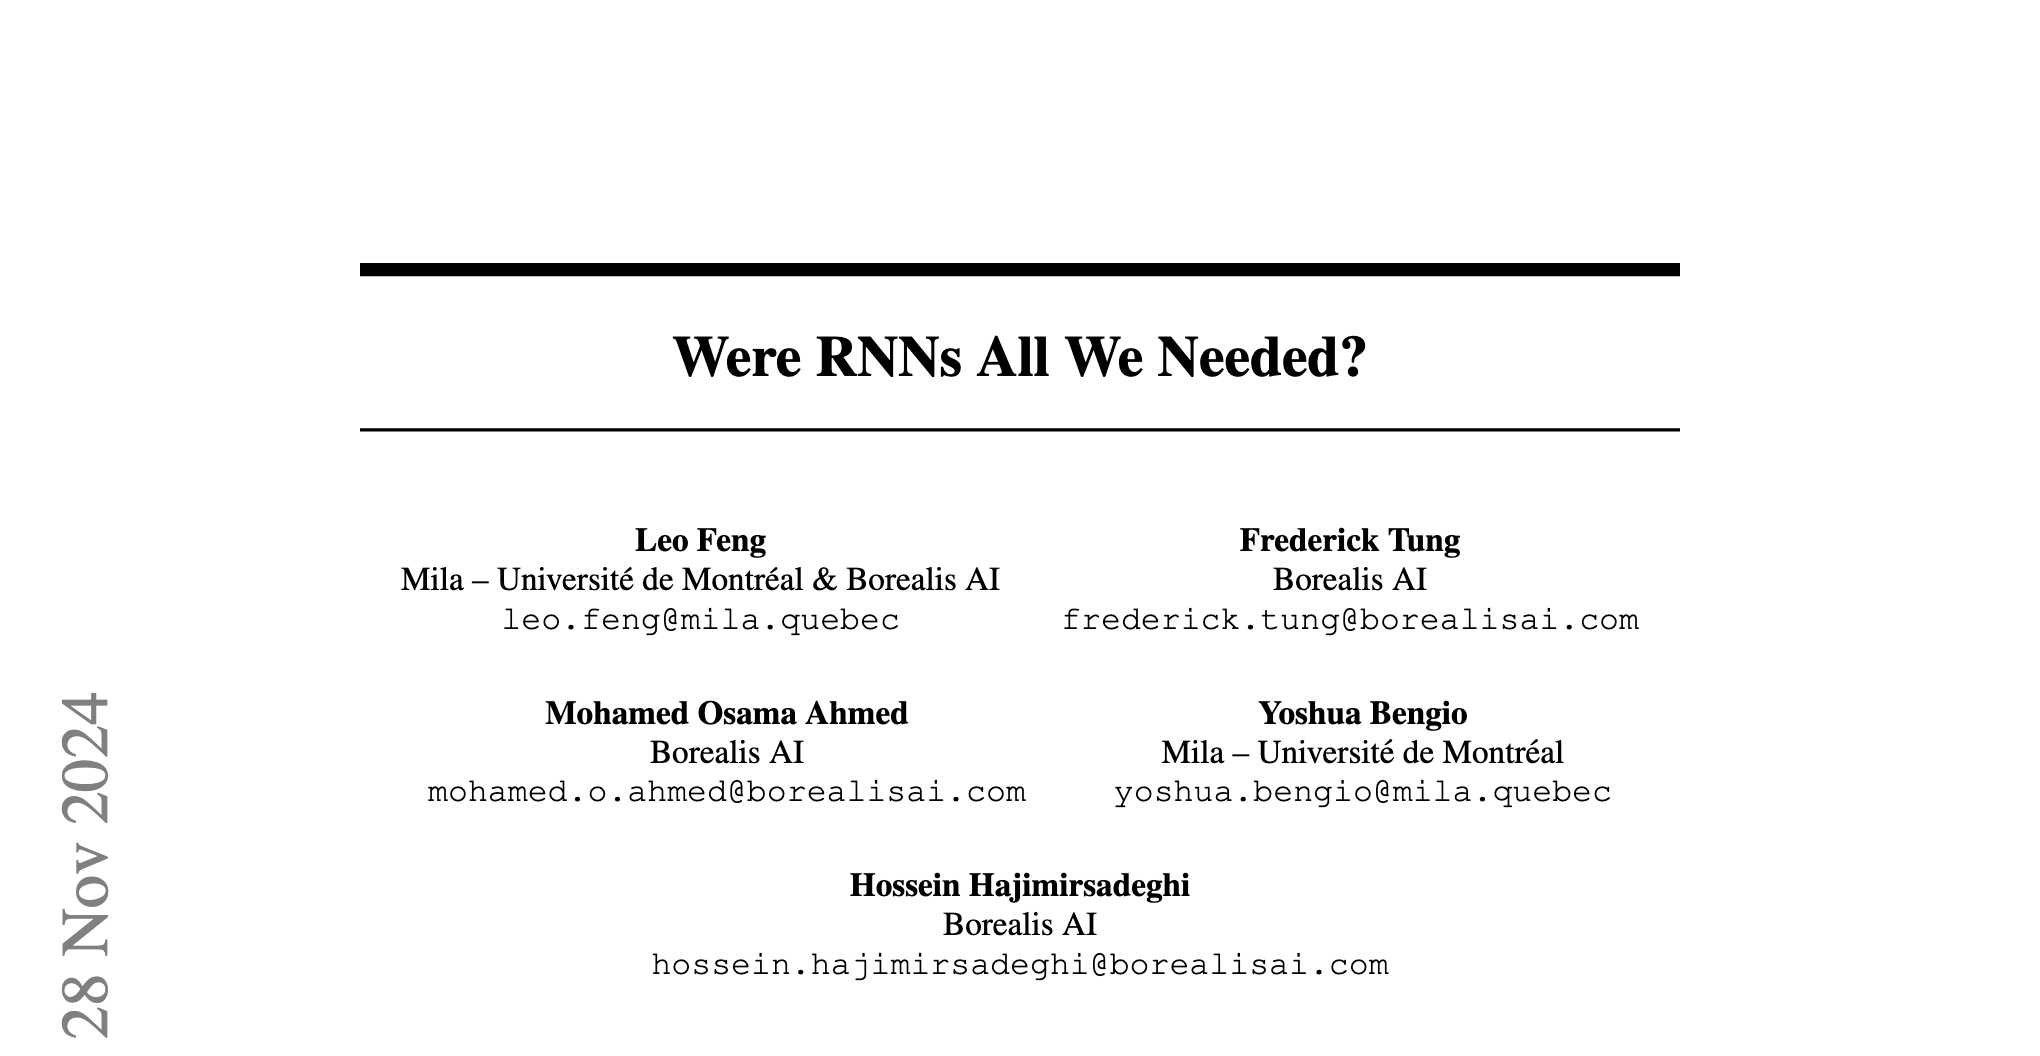

## 2.3 Bonus Section - Long Short-Term Memory (LSTM)

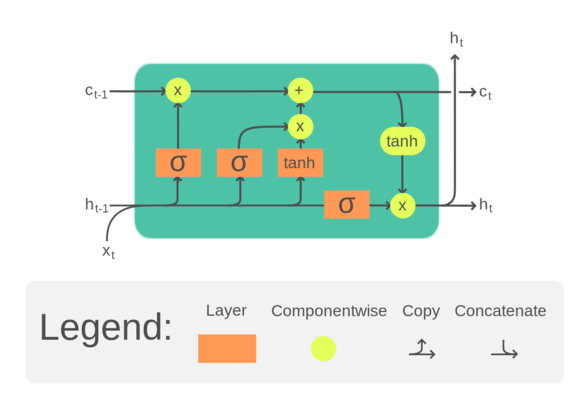

- LSTM cells were introduced in 1997 to address the issues that basic RNNs face with long-term dependencies.
- Main difference **gates** input, output and forget
    - allow the networks to selectively remember or forget information

- Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) introduced as a solution to the limitations of standard RNNs.

- Gating Mechanism: The gates control the flow of information into, out of, and through the cell state, making it possible to retain relevant information for long periods and discard irrelevant information.
- Has two state vectors, the memory state and the cell state
    - the memory state is equivalent to the hidden state in traditional RNNs
    - Cell State: The cell state acts as the long short-term memory that carries information across time steps relatively unchanged, allowing the network to remember important information over long sequences.

In [ ]:
# Define the LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Instantiate the model, loss function, and optimizer
lstm_model = SimpleLSTM(input_size, hidden_size, output_size)
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Training loop for LSTM
lstm_train_losses = []
lstm_test_losses = []

for epoch in range(num_epochs):
    lstm_model.train()
    outputs = lstm_model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        lstm_model.eval()
        with torch.no_grad():
            train_loss = criterion(lstm_model(X_train), y_train).item()
            test_loss = criterion(lstm_model(X_test), y_test).item()
            lstm_train_losses.append(train_loss)
            lstm_test_losses.append(test_loss)
            print(f'LSTM Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


In [ ]:
# Plotting the test losses for RNN and LSTM with a log scale
plt.figure(figsize=(12, 6))
plt.plot(range(10, num_epochs + 1, 10), rnn_test_losses, label='RNN Test Loss', color='blue', linestyle='--')
plt.plot(range(10, num_epochs + 1, 10), lstm_test_losses, label='LSTM Test Loss', color='green', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Comparison of RNN and LSTM Test Losses (Log Scale)')
plt.legend()
plt.show()


# 3. Understanding the Transformer


### Evolution from RNNs to Transformers
Before transformers, sequence modeling relied on Recurrent Neural Networks (RNNs) and their variants like Long Short-Term Memory (LSTM) networks. While powerful, these architectures had limitations:

1. Sequential Processing: RNNs process tokens one after another, making them slow to train.
2. Long-term Dependencies: RNNs struggle to maintain information over long sequences.

The Transformer architecture (introduced in the "Attention is All You Need" paper in 2017) solved these issues by:

- Processing all tokens in parallel
- Using attention mechanisms to directly model relationships between all positions
- Eliminating recurrence entirely

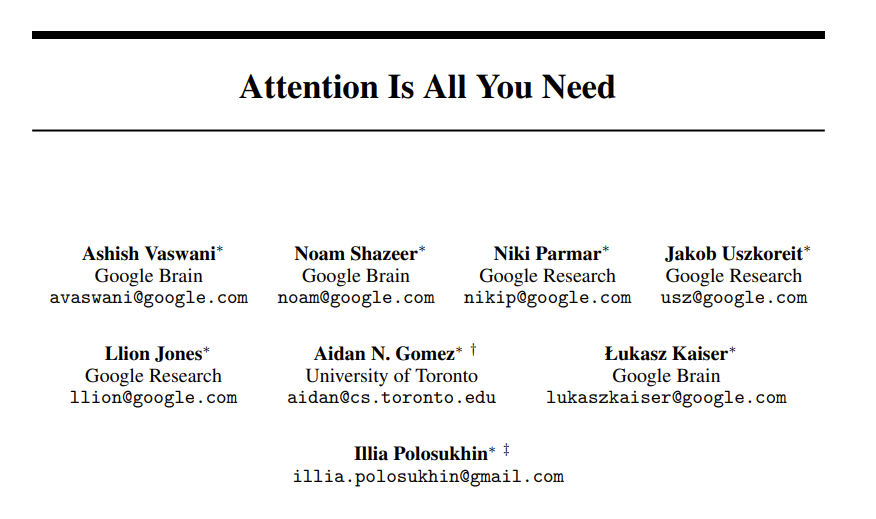

Let's look at the difference between these approaches:

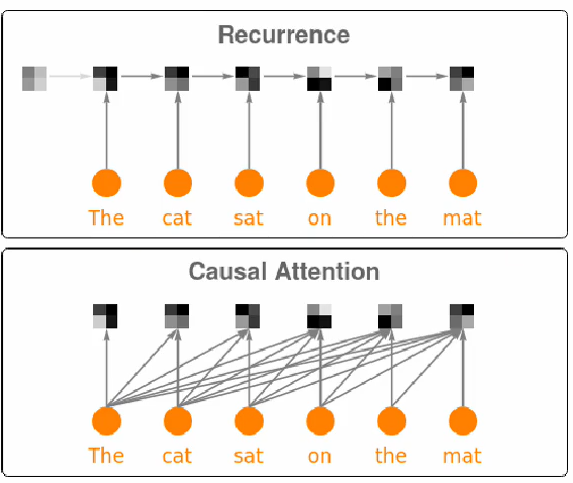

### Significance of GPT-Style Models
GPT (Generative Pre-trained Transformer) models are a family of transformer-based language models that:

1.Focus on autoregressive language modeling (predicting the next token)
2. Use only the decoder part of the original transformer architecture
3. Are pre-trained on massive text corpora
Can be fine-tuned for specific tasks

Starting with GPT-1 (2018), followed by GPT-2 (2019) and GPT-3 (2020), these models demonstrated that scaling up transformer architectures with more parameters and training data leads to increasingly impressive language capabilities.

We'll implement a simplified version of a GPT model that captures the core architectural elements.

## 3.1 Attention

Attention is the key innovation behind transformers. It allows the model to 'focus' on different parts of the input when producing outputs.

#### What is Attention?
At its core, attention answers the question: "For each token in my sequence, which other tokens should I focus on?"
In self-attention, we use three types of projections for each token:

- Query (Q): What information I'm looking for
- Key (K): What information I contain
- Value (V): The actual content I provide

Let's implement a simple example of attention to understand it:

## 3.2 Matching Queries and Keys
Consider database lookup - we have some query, and we check it against all the keys in the database - if there is a match, the value that corresponds to that key is returned as the result.
This is **hard matching** - an exact match is required.

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention

    Args:
        Q: Query matrix (batch_size, seq_length, d_k)
        K: Key matrix (batch_size, seq_length, d_k)
        V: Value matrix (batch_size, seq_length, d_v)
        mask: Optional mask to prevent attention to certain positions

    Returns:
        output: Attention output (batch_size, seq_length, d_v)
        attention_weights: Attention weights for visualization
    """
    # Compute attention scores
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)

    # Apply attention weights to values
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

In [ ]:
# example of hard matching, the names of the fruits are our keys and their prices in € are the value

database = {
    "apple": "€6",
    "banana": "€7.",
    "carrot": "€11.",
    "date": "€89"
}

# query
query = "banana"

# hard match lookup
def hard_match(database, query):
    if query in database:
        return database[query]
    else:
        return "No exact match found."

result = hard_match(database, query)
print(f"Hard Match Result: {result}")


## 3.3 Vocab and Similarity

### Vocabulary and Tokens

- **Tokens**: Tokens can be whole words, word chunks, or even individual characters. They are the smallest units of meaning in the model's vocabulary.

- **GPT-2 Vocabulary Size**: GPT-2 has a vocabulary consisting of 50,257 distinct tokens.

- **Token Vectors**: Each token in GPT-2's vocabulary is associated with a vector representation. For GPT-2, these vectors have a dimensionality of 768.

### Tokenization
Before processing text with a transformer, we need to convert it to a format the model can understand. This is where tokenization comes in.

#### Tokenization Strategies
- Word-level Tokenization: Split text on spaces/punctuation.
  - Pros: Intuitive, preserves word meaning
  - Cons: Large vocabulary, can't handle unseen words

- Character-level Tokenization: Treat each character as a token.
  - Pros: Small vocabulary, no out-of-vocabulary words
  - Cons: Very long sequences, loses word-level semantics

- Subword Tokenization: Break words into meaningful subunits.
  - Pros: Balance between vocab size and sequence length
  - Cons: More complex to implement


Modern language models like GPT use subword tokenization methods such as Byte-Pair Encoding (BPE).
Let's see a simple example of how tokenization works:

In [ ]:
# A simplistic word-level tokenizer for demonstration
def simple_tokenizer(text):
    """Split text into tokens and assign IDs"""
    # Create a simple vocabulary
    words = text.lower().split()
    vocab = sorted(set(words))
    word_to_id = {word: i for i, word in enumerate(vocab)}

    # Tokenize the text
    tokens = [word_to_id[word] for word in words]

    return tokens, word_to_id, vocab

# Example text
text = "The transformer architecture revolutionized natural language processing"
tokens, word_to_id, vocab = simple_tokenizer(text)

print("Vocabulary:", vocab)
print("Token IDs:", tokens)
print("Original text:", text)
print("Reconstructed text:", " ".join([vocab[token] for token in tokens]))

In practice, for a GPT implementation, we would use a more sophisticated tokenization approach like BPE. For simplicity in our workshop, we'll use a pre-built tokenizer when needed.

### Attention Mechanisms and Similarity

- **Dot-Product Similarity**: Attention mechanisms use dot-product similarity to measure how similar two vectors are.

- **Cosine Similarity**: Dot-product similarity indirectly measures the cosine of the angle between vectors. A higher dot product indicates a smaller angle and greater similarity between the vectors.

- **Significance**: This similarity measure helps the model identify and focus on related tokens within a sequence, enhancing its understanding and generation capabilities.

In [ ]:
# Define three vectors: A, B, and C with adjusted B and C
vector_a = np.array([4, 3])
vector_b = np.array([1.5, 2.5])  # Slightly less similar to A
vector_c = np.array([-3, -1])    # Negative dot product with A


In [ ]:
# Plot the vectors
plt.figure(figsize=(8, 8))
plt.quiver(0, 0, vector_a[0], vector_a[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vector A')
plt.quiver(0, 0, vector_b[0], vector_b[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector B (Less Similar to A)')
plt.quiver(0, 0, vector_c[0], vector_c[1], angles='xy', scale_units='xy', scale=1, color='g', label='Vector C (Negative Dot Product with A)')
# Set plot limits
plt.xlim(-4, 4)
plt.ylim(-4, 4)
# Add annotations
plt.text(vector_a[0], vector_a[1], 'A', fontsize=12, ha='right', color='r')
plt.text(vector_b[0], vector_b[1], 'B', fontsize=12, ha='right', color='b')
plt.text(vector_c[0], vector_c[1], 'C', fontsize=12, ha='right', color='g')
plt.title(f'Dot Product Similarity')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid()
plt.legend()
plt.show()


#### Dot Product Calculations:

1. Dot Product of A and B:
   $$
   \mathbf{A} \cdot \mathbf{B} = 4 \times 1.5 + 3 \times 2.5 = 6 + 7.5 = 13.5
   $$
   - This indicates a high degree of similarity.
  
  
2. Dot Product of A and C:
   $$
   \mathbf{A} \cdot \mathbf{C} = 4 \times (-3) + 3 \times (-1) = -12 - 3 = -15
   $$
    - This indicates they are dissimilar and pointing in opposite directions.

## 3.4 Bonus - Self-Attention Mechanism



Self-attention is a mechanism that allows a model to weigh the importance of different tokens in a sequence relative to each other. It helps the model capture dependencies and relationships between tokens, irrespective of their positions.

### Calculation of Q, K, and V

Given an input sequence $X$ with embeddings, the Queries ($Q$), Keys ($K$), and Values ($V$) are computed through learned linear transformations:

$$
Q = XW_Q
$$

$$
K = XW_K
$$

$$
V = XW_V
$$

where:
- $X$ is the matrix of input embeddings.
- $W_Q$, $W_K$, and $W_V$ are the ***learned weight matrices*** for Queries, Keys, and Values, respectively.


### Self-Attention Function

The self-attention output is calculated using the following function:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Here:
- $QK^T$ is the dot product of the Queries and the transpose of the Keys.
- $\frac{1}{\sqrt{d_k}}$ is a scaling factor where $d_k$ is the dimension of the Keys (or Queries).
- $\text{softmax}$ is applied to the scaled dot product to obtain the attention weights.
- These attention weights are then used to compute a weighted sum of the Values $V$.

This process allows the model to focus on different parts of the input sequence dynamically, enhancing its ability to understand context and relationships within the sequence.

## 3.5 Self-Attention in Action

In self-attention, each vector representing a token is transformed by considering its relationships with all other tokens in the sequence. This transformation results in a new vector for each token that captures the context and dependencies from the entire sequence.

In [ ]:
# Function to perform scaled dot-product attention
def scaled_dot_product_attention(Q, K, V):
    """
    Compute scaled dot-product attention

    Args:
        Q: Query matrix
        K: Key matrix
        V: Value matrix

    Returns:
        output: Attention output
        attention_weights: Attention weights
    """
    # Compute dot product of Q and K
    matmul_qk = torch.matmul(Q, K.transpose(-2, -1))

    # Scale the dot product
    d_k = K.size(-1)
    scaled_attention_logits = matmul_qk / np.sqrt(d_k)

    # Apply softmax to get attention weights
    attention_weights = torch.softmax(scaled_attention_logits, dim=-1)

    # Multiply attention weights by V
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

# Step 1: Define the input sequence for the sentence "The cat sat on the mat"
# Using one-hot-like embeddings for simplicity and clarity
tokens = ["The", "cat", "sat", "on", "the", "mat"]
seq_length = len(tokens)
embedding_dim = 3  # Using a small embedding dimension for clarity

X_np = np.array([
    [1, 0, 0],  # The
    [0, 1, 0],  # cat
    [0, 0, 1],  # sat
    [1, 1, 0],  # on
    [1, 0, 0],  # the
    [0, 1, 1]   # mat
])

# Convert to PyTorch tensor and add batch dimension
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 6, 3]

# Step 2: Initialize weight matrices for Q, K, and V
np.random.seed(42)  # For reproducibility
W_Q_np = np.random.rand(embedding_dim, embedding_dim)
W_K_np = np.random.rand(embedding_dim, embedding_dim)
W_V_np = np.random.rand(embedding_dim, embedding_dim)

# Convert to PyTorch tensors
W_Q = torch.tensor(W_Q_np, dtype=torch.float32)
W_K = torch.tensor(W_K_np, dtype=torch.float32)
W_V = torch.tensor(W_V_np, dtype=torch.float32)

# Step 3: Compute the Q, K, and V matrices
Q = torch.matmul(X, W_Q)  # Shape: [1, 6, 3]
K = torch.matmul(X, W_K)  # Shape: [1, 6, 3]
V = torch.matmul(X, W_V)  # Shape: [1, 6, 3]

# Step 4 & 5: Calculate the attention scores and weights
output, attention_weights = scaled_dot_product_attention(Q, K, V)

# Convert to numpy for visualization and printing
Q_np = Q.squeeze(0).numpy()
K_np = K.squeeze(0).numpy()
V_np = V.squeeze(0).numpy()
attention_weights_np = attention_weights.squeeze(0).numpy()
output_np = output.squeeze(0).numpy()

# Round all results to 3 decimal places for clarity
Q_np = np.round(Q_np, 3)
K_np = np.round(K_np, 3)
V_np = np.round(V_np, 3)
attention_weights_np = np.round(attention_weights_np, 3)
output_np = np.round(output_np, 3)

# Print the matrices
print("Query matrix (Q):")
print(Q_np)
print("\nKey matrix (K):")
print(K_np)
print("\nValue matrix (V):")
print(V_np)
print("\nAttention weights:")
print(attention_weights_np)
print("\nOutput:")
print(output_np)

# Visualize attention weights
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights_np, cmap='viridis')
plt.colorbar()
plt.xticks(np.arange(len(tokens)), tokens)
plt.yticks(np.arange(len(tokens)), tokens)
plt.xlabel('Key tokens')
plt.ylabel('Query tokens')
plt.title('Self-Attention Weights')

# Add text annotations
for i in range(len(tokens)):
    for j in range(len(tokens)):
        text = plt.text(j, i, f'{attention_weights_np[i, j]:.3f}',
                       ha="center", va="center", color="w" if attention_weights_np[i, j] > 0.2 else "black")

plt.tight_layout()
plt.show()

# Create a more intuitive visualization showing how each word attends to others
plt.figure(figsize=(12, 8))

# For each token (as a query), show how it attends to all other tokens
for i, token in enumerate(tokens):
    plt.subplot(2, 3, i+1)
    plt.bar(tokens, attention_weights_np[i])
    plt.title(f"Attention from '{token}'")
    plt.ylim(0, 1)
    if i >= 3:  # For bottom row
        plt.xticks(rotation=45)
    else:  # For top row
        plt.xticks([])  # Hide x labels for top row

plt.tight_layout()
plt.show()

# Explain what the model learned
print("\nInterpretation of attention patterns:")
print("------------------------------------")
for i, token in enumerate(tokens):
    max_attention_idx = np.argmax(attention_weights_np[i])
    if max_attention_idx == i:
        print(f"'{token}' primarily attends to itself")
    else:
        print(f"'{token}' primarily attends to '{tokens[max_attention_idx]}'")

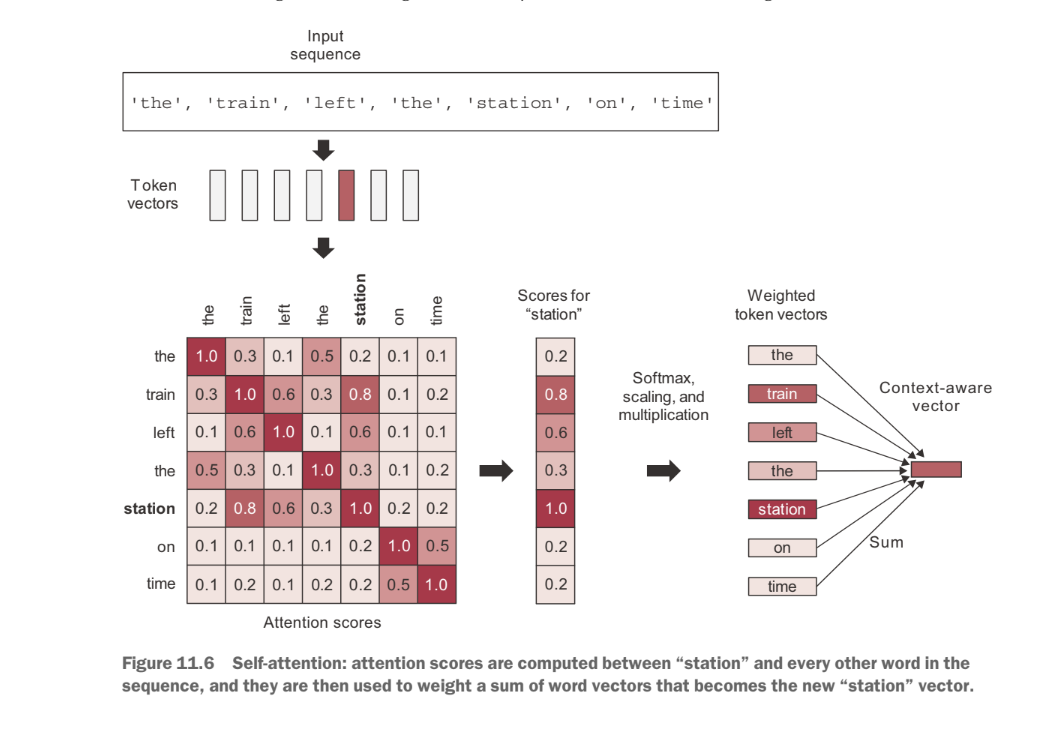

# 3.6 From Attention to Transformers

- Multi-Head Attention
- Position-Wise Feed-Forward Networks
- Add & Norm
- Positional Encoding
- Stacking Layers
- Encoder-Decoder Architecture

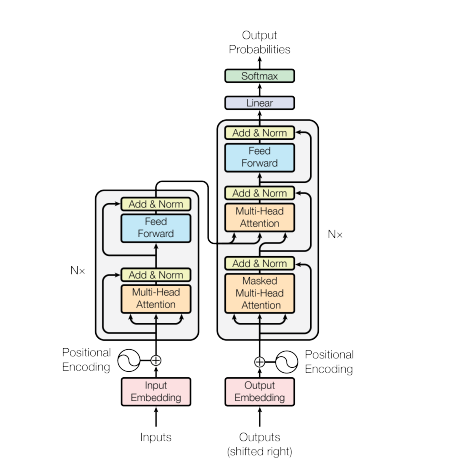

#### 3.6.1 Multi-Headed Attention
In practice, transformers use multi-head attention, which:

- Splits the attention computation into multiple "heads"
- Allows each head to focus on different aspects of the relationships
- Concatenates the results from all heads
- Allows for encanched contextual understanding

**Multi-Headed Attention**: This mechanism allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function, it runs multiple attention mechanisms in parallel (heads). The outputs are then concatenated and linearly transformed into the expected dimension.

Let's implement a simplified multi-head attention module:

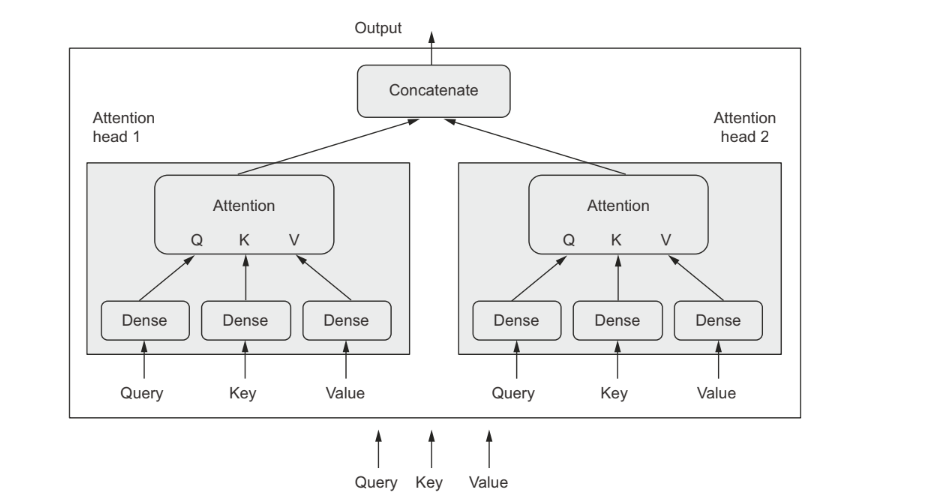

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Initialize Multi-Head Attention module.

        Args:
            d_model: The dimension of the input/output embeddings (model dimension)
            num_heads: Number of attention heads to use
        """
        super(MultiHeadAttention, self).__init__()
        # Ensure model dimension is divisible by number of heads for clean splitting
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model  # Total embedding dimension
        self.num_heads = num_heads  # Number of attention heads
        self.d_k = d_model // num_heads  # Dimension of each head's key/query/value vectors

        # Create four linear projections:
        # - W_q: Projects input sequence to create query vectors
        # - W_k: Projects input sequence to create key vectors
        # - W_v: Projects input sequence to create value vectors
        # - W_o: Final output projection after concatenating all head outputs
        self.W_q = nn.Linear(d_model, d_model)  # Query projection
        self.W_k = nn.Linear(d_model, d_model)  # Key projection
        self.W_v = nn.Linear(d_model, d_model)  # Value projection
        self.W_o = nn.Linear(d_model, d_model)  # Output projection

    def split_heads(self, x):
        """
        Split the last dimension of input tensor into (num_heads, d_k).
        Reshape from (batch_size, seq_length, d_model) to (batch_size, num_heads, seq_length, d_k)
        This separates the embedding dimension into multiple heads for parallel attention computation.

        Args:
            x: Input tensor of shape (batch_size, seq_length, d_model)

        Returns:
            Reshaped tensor with shape (batch_size, num_heads, seq_length, d_k)
        """
        batch_size, seq_length, d_model = x.size()
        # Reshape to (batch_size, seq_length, num_heads, d_k) then transpose dimensions
        # to get (batch_size, num_heads, seq_length, d_k) for parallel processing of heads
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        """
        Combine the multiple heads back into original shape.
        Reshape from (batch_size, num_heads, seq_length, d_k) to (batch_size, seq_length, d_model)
        This reunifies the separate attention heads after computation.

        Args:
            x: Multi-head tensor of shape (batch_size, num_heads, seq_length, d_k)

        Returns:
            Combined tensor with shape (batch_size, seq_length, d_model)
        """
        batch_size, num_heads, seq_length, d_k = x.size()
        # Transpose back to (batch_size, seq_length, num_heads, d_k) then reshape
        # to (batch_size, seq_length, d_model) to get original dimensionality
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        Forward pass of Multi-Head Attention.

        Args:
            Q: Query tensor of shape (batch_size, seq_length, d_model)
            K: Key tensor of shape (batch_size, seq_length, d_model)
            V: Value tensor of shape (batch_size, seq_length, d_model)
            mask: Optional mask to prevent attending to certain positions (used for causal/padding masks)

        Returns:
            output: Output tensor of shape (batch_size, seq_length, d_model)
            attention_weights: List of attention weight matrices for each head
        """
        batch_size = Q.size(0)

        # Step 1: Apply linear projections to Q, K, V and split into multiple heads
        # This creates separate query, key, and value vectors for each attention head
        q = self.split_heads(self.W_q(Q))  # (batch_size, num_heads, seq_length, d_k)
        k = self.split_heads(self.W_k(K))  # (batch_size, num_heads, seq_length, d_k)
        v = self.split_heads(self.W_v(V))  # (batch_size, num_heads, seq_length, d_k)

        # Step 2: Apply scaled dot-product attention to each head separately
        # This is the core attention calculation for each head
        head_outputs = []  # Will store the output of each attention head
        attention_weights = []  # Will store the attention weights of each head

        # Loop through each attention head and compute attention separately
        for i in range(self.num_heads):
            # Extract this head's query, key, and value vectors
            # squeeze(1) removes the head dimension after selecting the specific head
            out, weights = scaled_dot_product_attention(
                q[:, i:i+1].squeeze(1),  # Select queries for head i
                k[:, i:i+1].squeeze(1),  # Select keys for head i
                v[:, i:i+1].squeeze(1),  # Select values for head i
                mask  # Apply the same mask to all heads
            )
            head_outputs.append(out)  # Store this head's output
            attention_weights.append(weights)  # Store this head's attention weights

        # Step 3: Concatenate the outputs from all heads
        # This combines the different information captured by each attention head
        multi_head_output = torch.cat(head_outputs, dim=-1)  # Concatenate along the embedding dimension

        # Step 4: Apply final linear projection to get the output
        # This mixes information across different heads and projects back to model dimension
        output = self.W_o(multi_head_output)

        return output, attention_weights

#### 3.6.2 Positional Encoding
Unlike RNNs, transformers process all tokens in parallel so they do not inherently understand the order of tokens, positional encoding is added to the input embeddings to inject information about the position of the tokens in the sequence.
- This is done through positional encoding. Positional encoding injects sequence order information into a Transformer model by assigning each position a unique vector using sine and cosine functions of varying frequencies. Each position's encoding contains a distinct pattern of high and low frequency components that allows the model to understand both absolute position and relative distances between tokens. These sinusoidal patterns create geometrically meaningful representations where similar positions have similar encodings, while maintaining constant amplitude across all sequence positions.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_seq_length, d_model):
    """
    Create positional encoding matrix as described in the "Attention Is All You Need" paper.

    Positional encoding uses sine and cosine functions of different frequencies to create
    unique position vectors that help the model understand sequence order.

    Args:
        max_seq_length: Maximum sequence length (number of tokens/positions)
        d_model: Dimension of the model embeddings

    Returns:
        Positional encoding tensor of shape (1, max_seq_length, d_model)
    """
    # Input validation
    if not isinstance(max_seq_length, int) or max_seq_length <= 0:
        raise ValueError("max_seq_length must be a positive integer")
    if not isinstance(d_model, int) or d_model <= 0:
        raise ValueError("d_model must be a positive integer")
    if d_model % 2 != 0:
        print(f"Warning: d_model ({d_model}) is not even. The last dimension will use sin instead of alternating sin/cos.")

    # Initialize a zero matrix for positional encodings
    # Shape: (max_seq_length, d_model)
    pe = torch.zeros(max_seq_length, d_model)

    # Create a vector of positions from 0 to max_seq_length-1
    # Shape: (max_seq_length, 1)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

    # Create scaling factor for each dimension
    # This creates different frequencies for the sinusoidal functions
    # Using pow is numerically more stable than exp(-log())
    # Shape: (d_model/2)
    div_term = torch.pow(
        10000.0,
        -torch.arange(0, d_model, 2).float() / d_model
    )

    # Apply sine to even indices (0, 2, 4, ...)
    # For each position, calculate sine values at different frequencies
    # Shape: (max_seq_length, d_model/2)
    pe[:, 0::2] = torch.sin(position * div_term)

    # Apply cosine to odd indices (1, 3, 5, ...)
    # For each position, calculate cosine values at different frequencies
    # Shape: (max_seq_length, d_model/2)
    cos_indices = torch.arange(1, d_model, 2)
    pe[:, cos_indices] = torch.cos(position * div_term[:len(cos_indices)])

    # Add batch dimension for compatibility with model input shape
    # Final shape: (1, max_seq_length, d_model)
    return pe.unsqueeze(0)

# Visualize positional encodings
max_seq_length = 100
d_model = 128
pos_encoding = positional_encoding(max_seq_length, d_model)

plt.figure(figsize=(12, 6))
plt.imshow(pos_encoding[0].numpy(), aspect='auto', cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.colorbar()
plt.title('Positional Encoding')
plt.show()

# Demonstrate a specific position encoding
def show_position_example(position_idx=10):
    """Show encoding for a specific position"""
    plt.figure(figsize=(10, 4))
    plt.plot(pos_encoding[0, position_idx, :].numpy())
    plt.title(f'Encoding Pattern for Position {position_idx}')
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

    # Show first 20 dimensions
    plt.figure(figsize=(10, 4))
    plt.plot(pos_encoding[0, position_idx, :20].numpy(), 'o-')
    plt.title(f'First 20 Dimensions of Position {position_idx} Encoding')
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Uncomment to visualize a specific position
show_position_example(15)

### 3.6.3 Position-Wise Feed-Forward Networks:
Following multi-head attention, the output undergoes further processing through a feed-forward neural network, applied independently to each position. This consists of two linear transformations with a ReLU activation in between.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network (FFN) as described in the "Attention Is All You Need" paper.

    This module consists of two linear transformations with a GELU activation in between:
    FFN(x) = Linear2(GELU(Linear1(x)))

    The first transformation expands the dimension from d_model to d_ff (typically 4x larger),
    and the second transformation projects back to the original dimension d_model.
    This expansion and projection pattern allows the network to capture complex interactions.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Initialize the Feed-Forward Network.

        Args:
            d_model: Dimension of model embeddings (input and output dimension)
            d_ff: Dimension of the intermediate (hidden) layer, typically 4*d_model
            dropout: Dropout probability to prevent overfitting (default: 0.1)
        """
        super(FeedForward, self).__init__()

        # First linear transformation that projects from d_model to d_ff (expansion)
        self.linear1 = nn.Linear(d_model, d_ff)

        # Second linear transformation that projects back from d_ff to d_model (projection)
        self.linear2 = nn.Linear(d_ff, d_model)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Initialize weights for better training dynamics
        self._init_weights()

    def _init_weights(self):
        """
        Initialize the weights of the linear layers.

        Uses a normal distribution with a small standard deviation to prevent
        large initial values, which can cause unstable gradients.
        """
        nn.init.normal_(self.linear1.weight, std=0.02)
        nn.init.normal_(self.linear2.weight, std=0.02)
        nn.init.zeros_(self.linear1.bias)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, x):
        """
        Apply the feed-forward network to the input.

        The computation flow is:
        1. Project input from d_model to d_ff dimensions (expansion)
        2. Apply GELU activation function
        3. Apply dropout for regularization
        4. Project back from d_ff to d_model dimensions (projection)

        Args:
            x: Input tensor of shape (batch_size, seq_length, d_model)

        Returns:
            Output tensor of shape (batch_size, seq_length, d_model)
        """
        # First linear layer expands from d_model to d_ff
        # GELU activation is used instead of ReLU as it often performs better in Transformers
        # GELU(x) is approximately x * sigmoid(1.702 * x), providing a smooth activation
        expanded = F.gelu(self.linear1(x))

        # Apply dropout for regularization
        expanded = self.dropout(expanded)

        # Second linear layer projects back to original d_model dimension
        output = self.linear2(expanded)

        return output


# Example usage:
if __name__ == "__main__":
    # Parameters
    batch_size = 8
    seq_length = 16
    d_model = 512
    d_ff = 2048

    # Create sample input: (batch_size, seq_length, d_model)
    x = torch.randn(batch_size, seq_length, d_model)

    # Initialize the Feed-Forward Network
    ffn = FeedForward(d_model, d_ff)

    # Forward pass
    output = ffn(x)

    # Check output shape
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Expected shape: (batch_size={batch_size}, seq_length={seq_length}, d_model={d_model})")

### 3.6.4 Layer Normalization

#### What is Layer Normalization?
- Layer Normalization standardizes the inputs across features for each individual example, rather than across the batch like Batch Normalization. Think of it as giving each input its own "personal scale" - making sure values aren't too large or too small.

#### How it works:
- Normalization: For each individual input, it calculates the average and spread of values across all features.
-  Standardization: It then adjusts all features to have an average of 0 and a standard deviation of 1 (like converting heights from different measurement systems to a standard scale).
- Rescaling: Finally, it applies learnable parameters (gamma and beta) that allow the network to determine how much standardization is needed at each stage of training.

#### Why it's important:
- Training stability: Prevents extremely large or small values that can cause training to fail
- Faster convergence: Helps networks learn more quickly by keeping values in a reasonable range
- Sequence handling: Works well with variable-length sequences unlike Batch Normalization
- Independence: Each example is normalized individually, making it useful for small batch sizes or online learning

In [ ]:
import torch
import torch.nn as nn


class LayerNorm(nn.Module):
    """
    Layer Normalization as described in the paper "Layer Normalization" (Ba et al., 2016).

    Layer Normalization stabilizes training by normalizing the activations of the previous
    layer for each input sample independently, rather than across a batch like Batch Normalization.
    This makes it particularly suitable for sequence models where sequence lengths may vary.

    The normalization is performed along the feature dimension (last dimension) and includes
    learnable scale (gamma) and shift (beta) parameters to maintain the network's representational power.
    """
    def __init__(self, d_model, eps=1e-6):
        """
        Initialize the Layer Normalization module.

        Args:
            d_model: Dimension of the model (number of features)
            eps: Small constant added to the denominator for numerical stability (default: 1e-6)
        """
        super(LayerNorm, self).__init__()

        # Learnable scale parameter (gamma) initialized to ones
        # This allows the network to modulate the magnitude of normalized features
        self.gamma = nn.Parameter(torch.ones(d_model))

        # Learnable shift parameter (beta) initialized to zeros
        # This allows the network to shift the normalized features
        self.beta = nn.Parameter(torch.zeros(d_model))

        # Small constant for numerical stability
        self.eps = eps

    def forward(self, x):
        """
        Apply layer normalization to the input.

        The computation normalizes each input sample independently by:
        1. Computing the mean and standard deviation across the feature dimension
        2. Normalizing the features to zero mean and unit variance
        3. Scaling and shifting with learnable parameters gamma and beta

        Args:
            x: Input tensor of shape (..., d_model) where the last dimension
               is the feature dimension to be normalized

        Returns:
            Normalized tensor of the same shape as the input
        """
        # Calculate mean across the feature dimension (last dimension)
        # keepdim=True preserves the dimension for proper broadcasting
        mean = x.mean(-1, keepdim=True)

        # Calculate standard deviation across the feature dimension
        # Using std directly is more efficient than sqrt(variance)
        std = x.std(-1, keepdim=True)

        # Normalize to zero mean and unit variance
        # Add epsilon to prevent division by zero
        normalized = (x - mean) / (std + self.eps)

        # Scale and shift with learnable parameters
        # This preserves the network's representational power
        return self.gamma * normalized + self.beta


# Example usage:
if __name__ == "__main__":
    # Example parameters
    batch_size = 8
    seq_length = 16
    d_model = 512

    # Create sample input: (batch_size, seq_length, d_model)
    x = torch.randn(batch_size, seq_length, d_model)

    # Initialize Layer Normalization
    layer_norm = LayerNorm(d_model)

    # Apply normalization
    normalized_x = layer_norm(x)

    # Verify output shape
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {normalized_x.shape}")

    # Verify normalization effect
    # Check the statistics of the normalized_x output
    # The mean should be close to 0 and std close to 1 * gamma + beta
    print(f"Normalized output mean: {normalized_x.mean().item():.6f}")
    print(f"Normalized output std: {normalized_x.std().item():.6f}")

    # We can also verify the intermediate normalization (before gamma and beta)
    normalized_only = (x - x.mean(-1, keepdim=True)) / (x.std(-1, keepdim=True) + 1e-6)
    print(f"Pre-gamma/beta normalized mean: {normalized_only.mean().item():.6f}")
    print(f"Pre-gamma/beta normalized std: {normalized_only.std().item():.6f}")

# 4. Building Our Own GPT
- **Generative Pre-Trained Transformer**

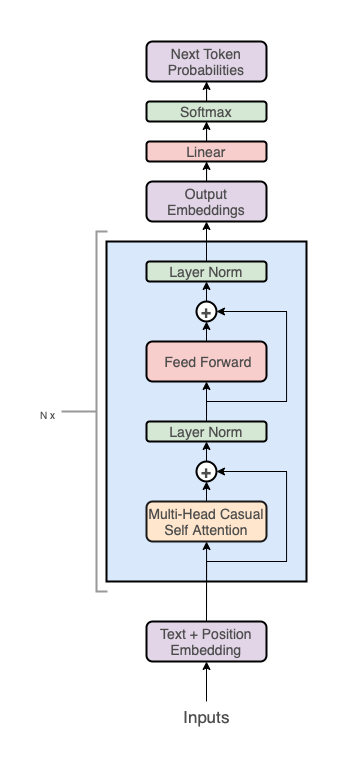


- Generative - generates text
- Pre-trained - has been trained on large amounts of text from the internet. GPT-2 was trained on 45GB of text or about 10 billion words.
- Transformer - decoder only


- implement a GPT with numpy

- load the trained GPT-2 weights (I don't have a bunch of GPUs lying aroud this house so we'll take the publically available weights)

In [ ]:
import os
os.chdir("picoGPT")

In [ ]:
# !git clone https://github.com/jaymody/picoGPT.git

In [ ]:
 # !pip install -r requirements.txt

In [ ]:
# GELU activation function used in GPT models
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))


In [ ]:
# Softmax function for transforming values into probabilities
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


In [ ]:
# Layer normalization to normalize the input and improve training stability
def layer_norm(x, g, b, eps: float = 1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    x = (x - mean) / np.sqrt(variance + eps)  # normalize x to have mean=0 and var=1 over last axis
    return g * x + b  # scale and offset with gamma/beta params

- Layer Normalization: Normalizes the inputs across the features.
- Mean and Variance: Calculated across the last axis.
- Epsilon (eps): A small number to avoid division by zero.
- Scale (g) and Shift (b): Parameters learned during training.
- Purpose: Stabilizes and accelerates training by normalizing inputs.

In [ ]:
# Linear transformation (fully connected layer)
def linear(x, w, b):  # [m, in], [in, out], [out] -> [m, out]
    return x @ w + b

- Linear Layer: Performs a linear transformation.
- Matrix Multiplication (@): Multiplies input x with weights w.
- Bias Addition (b): Adds bias to the result.
- Purpose: Applies a learned linear transformation to the input data.

In [ ]:
# Feed-forward network component of the transformer
def ffn(x, c_fc, c_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # project up
    a = gelu(linear(x, **c_fc))  # [n_seq, n_embd] -> [n_seq, 4*n_embd]

    # project back down
    x = linear(a, **c_proj)  # [n_seq, 4*n_embd] -> [n_seq, n_embd]

    return x

Feed Forward Network: Consists of two linear transformations with a GELU activation in between.

In [ ]:
# Scaled dot-product attention mechanism
def attention(q, k, v, mask):  # [n_q, d_k], [n_k, d_k], [n_k, d_v], [n_q, n_k] -> [n_q, d_v]
    return softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v

# Multi-head attention mechanism
def mha(x, c_attn, c_proj, n_head):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # qkv projection
    x = linear(x, **c_attn)  # [n_seq, n_embd] -> [n_seq, 3*n_embd]

    # split into qkv
    qkv = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> [3, n_seq, n_embd]

    # split into heads
    qkv_heads = list(map(lambda x: np.split(x, n_head, axis=-1), qkv))  # [3, n_seq, n_embd] -> [3, n_head, n_seq, n_embd/n_head]

    # causal mask to hide future inputs from being attended to
    causal_mask = (1 - np.tri(x.shape[0], dtype=x.dtype)) * -1e10  # [n_seq, n_seq]

    # perform attention over each head
    out_heads = [attention(q, k, v, causal_mask) for q, k, v in zip(*qkv_heads)]  # [3, n_head, n_seq, n_embd/n_head] -> [n_head, n_seq, n_embd/n_head]

    # merge heads
    x = np.hstack(out_heads)  # [n_head, n_seq, n_embd/n_head] -> [n_seq, n_embd]

    # out projection
    x = linear(x, **c_proj)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x

In [ ]:
# Single transformer block consisting of multi-head attention and feed-forward network
def transformer_block(x, mlp, attn, ln_1, ln_2, n_head):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # multi-head causal self attention
    x = x + mha(layer_norm(x, **ln_1), **attn, n_head=n_head)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # position-wise feed forward network
    x = x + ffn(layer_norm(x, **ln_2), **mlp)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x

- Transformer Block: A single block in a Transformer model.
    - Multi-Head Attention: Applies attention after layer normalization.
    - Feed Forward Network: Applies FFN after another layer normalization.
    - Residual Connections: Adds the input to the output of each sub-layer to help with gradient flow.
    - Purpose: Builds the core of the Transformer architecture by stacking multiple such blocks.

In [ ]:
# The main GPT-2 model
def gpt2(inputs, wte, wpe, blocks, ln_f, n_head):  # [n_seq] -> [n_seq, n_vocab]
    # token + positional embeddings
    x = wte[inputs] + wpe[range(len(inputs))]  # [n_seq] -> [n_seq, n_embd]

    # forward pass through n_layer transformer blocks
    for block in blocks:
        x = transformer_block(x, **block, n_head=n_head)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # projection to vocab
    x = layer_norm(x, **ln_f)  # [n_seq, n_embd] -> [n_seq, n_embd]
    return x @ wte.T  # [n_seq, n_embd] -> [n_seq, n_vocab]

- GPT-2 Model: A generative pre-trained transformer.
    - Embeddings (wte, wpe): Converts input tokens and their positions to vectors.
    - Transformer Blocks: Applies a series of transformer blocks to the input.
    - Final Layer Normalization (ln_f): Normalizes the final output.
    - Projection to Vocabulary: Projects the output to the vocabulary space to predict the next token.
    - Purpose: Generates text by predicting the next token in a sequence.

In [ ]:
# Function to generate text given a prompt
def generate(inputs, params, n_head, n_tokens_to_generate):
    from tqdm import tqdm

    for _ in tqdm(range(n_tokens_to_generate), "generating"):  # auto-regressive decode loop
        logits = gpt2(inputs, **params, n_head=n_head)  # model forward pass
        next_id = np.argmax(logits[-1])  # greedy sampling
        inputs.append(int(next_id))  # append prediction to input

    return inputs[len(inputs) - n_tokens_to_generate :]  # only return generated ids


- Text Generation: Generates text by iteratively predicting the next token.
    - Auto-Regressive Loop: Continuously generates new tokens based on the previous tokens.
    - Greedy Sampling: Chooses the token with the highest probability at each step.
    - Purpose: Produces coherent and contextually relevant text sequences.

In [ ]:
# Main function to run the GPT-2 model
def main(prompt: str, n_tokens_to_generate: int = 38, model_size: str = "124M", models_dir: str = "models"):
    from utils import load_encoder_hparams_and_params

    # load encoder, hparams, and params from the released open-ai gpt-2 files
    encoder, hparams, params = load_encoder_hparams_and_params(model_size, models_dir)

    # encode the input string using the BPE tokenizer
    input_ids = encoder.encode(prompt)

    # make sure we are not surpassing the max sequence length of our model
    assert len(input_ids) + n_tokens_to_generate < hparams["n_ctx"]

    # generate output ids
    output_ids = generate(input_ids, params, hparams["n_head"], n_tokens_to_generate)

    # decode the ids back into a string
    output_text = encoder.decode(output_ids)

    return output_text



- Main Function: Orchestrates the text generation process.
    - Load Model Parameters: Loads the necessary parameters and configurations.
    - Encode Prompt: Converts the input text to token IDs.
    - Generate Text: Calls the generate function to produce the output tokens.
    - Decode Output: Converts the generated token IDs back to text.
    - Purpose: Provides an interface to generate text given an initial prompt.

In [ ]:
# Run the model
prompt = "what do you know about gpt5? " # '..are lost' J. R. R. Tolkein
output_text = main(prompt)
print(output_text)


# Pretraining vs Instruction Tuning
### Pretraining

1. **Objective**: Train the model to predict the next word in a sentence, learning general language patterns and knowledge.
2. **Data**: Uses a vast and diverse corpus of unlabeled text from the internet.
3. **Process**: Involves large-scale training to understand grammar, facts, and reasoning.
4. **Outcome**: Produces a general-purpose language model capable of generating coherent text.

### Instruction Tuning

1. **Objective**: Refine the pretrained model to follow specific instructions and perform particular tasks.
2. **Data**: Uses labeled datasets with clear instructions and desired outputs.
3. **Process**: Fine-tunes the model using supervised learning and reinforcement learning from human feedback.
4. **Outcome**: Enhances the model's ability to follow instructions and produce task-specific outputs.

### Comparison

- **Scope**: Pretraining is broad and general; instruction tuning is narrow and specific.
- **Data Requirement**: Pretraining uses diverse, unlabeled text; instruction tuning uses high-quality, labeled data.
- **Complexity**: Pretraining is more resource-intensive; instruction tuning is focused and task-specific.
- **Integration**: Pretraining provides foundational knowledge; instruction tuning customizes the model for specific applications.

## 4.1 Limitations

1. Efficiency
2. Scalability
3. Training
4. Preprocessing and Tokenization
5. Optimization Techniques

This script demonstrates a simplified implementation of the GPT-2 architecture. However, it has several limitations compared to a real GPT-2 model:

1. **Efficiency**: This code is written in pure NumPy, which is not optimized for performance compared to frameworks like TensorFlow or PyTorch used in real GPT models. These frameworks leverage hardware acceleration, which is crucial for training and inference of large models.

2. **Scalability**: Real GPT models are trained on massive datasets using distributed computing across many GPUs or TPUs. This script lacks the infrastructure to handle such large-scale data and computation.

3. **Training**: The script only implements inference (generating text) and does not cover the training process. Training involves gradient descent, backpropagation, and other techniques not addressed here.

4. **Preprocessing and Tokenization**: The script uses a placeholder for loading pre-trained models and tokenizers (`load_encoder_hparams_and_params`). In practice, these components are complex and involve handling various languages, subword tokenization, and more.

5. **Optimization Techniques**: Real GPT models use advanced techniques like mixed-precision training, gradient accumulation, and various forms of regularization that are not covered in this simplified version.


## 4.2 Next Steps

1. Learn Deep Learning Frameworks
2. Understand Training Processes
3. Advanced Preprocessing
4. Model Architectures
5. Performance Optimization
6. Experiment with Pre-trained Models

### 4.2.1 Real Next Steps

~~1. Learn Deep Learning Frameworks~~  
~~2. Understand Training Processes~~  
~~3. Advanced Preprocessing~~  
~~4. Model Architectures~~  
~~5. Performance Optimization~~  
~~6. Experiment with Pre-trained Models~~
#### 0. Work on this notebook and then work through Karpathy Zero to Hero Series
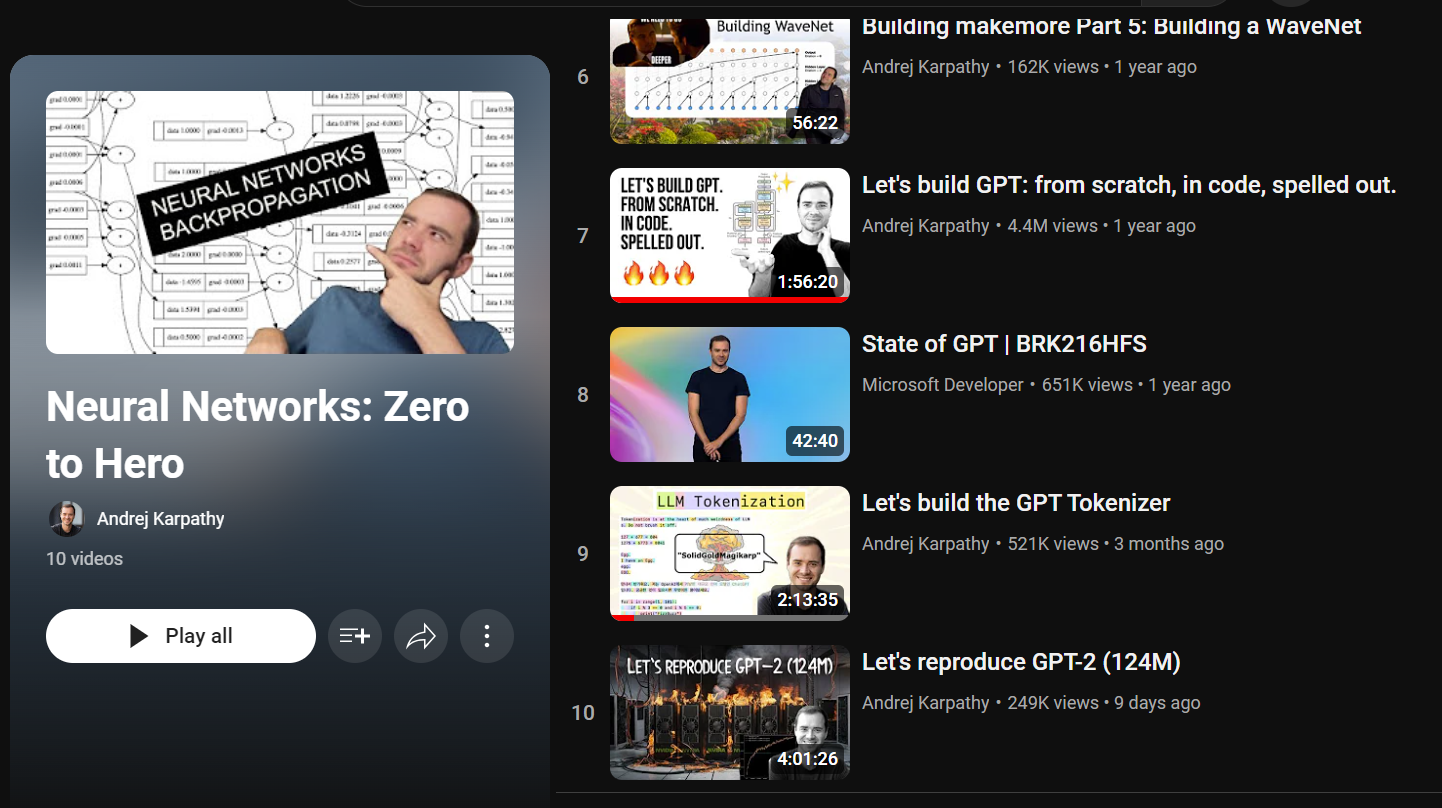

# 5. Wrap-up

References:
* Hands on Machine Learning with Scikit-Learn, Keras and Tensorflow by Aurélien Géron Third Edition, Chapter 10 - Introduction to Artificial Neural Networks with Keras https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/
* Building GPT implentation adapted from https://github.com/jaymody/picoGPT
* Deep Learning with Python by François Chollet https://www.manning.com/books/deep-learning-with-python-second-edition
* The Unreasonable Effectiveness of Recurrent Neural Networks https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* Gradient Descent Image taken from https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2